In [ ]:
#Instalando o Pacote da Basedosdados
! pip install basedosdados -q

In [ ]:
#Importando as bibliotecas
import basedosdados as bd
import pandas as pd
import numpy as np

In [ ]:
#Quais são os principais estados exportadores de Soja no Brasil? E seus principais destinos?
query = '''
SELECT sigla_uf,  id_pais, SUM(peso_liquido_kg) as peso_liquido_kg, SUM(valor_fob_dolar) as valor_fob_dolar
FROM (
  SELECT  id_municipio, sigla_uf, id_sh4, id_pais, SUM(peso_liquido_kg) as peso_liquido_kg, SUM(valor_fob_dolar) as valor_fob_dolar
  FROM `basedosdados.br_me_comex_stat.municipio_exportacao`
  WHERE id_sh4 = '1201'
  GROUP BY  id_municipio, sigla_uf, id_sh4, id_pais
) exportacao
GROUP BY sigla_uf, id_pais
ORDER BY valor_fob_dolar DESC
'''
df = bd.read_sql(query, billing_project_id='seu-billing-id')

Downloading: 100%|██████████| 960/960 [00:00<00:00, 1083.15rows/s]


In [ ]:
# Evolução da Exportação de Soja no MT de 1997 a 2022
query = '''
SELECT sigla_uf, ano, SUM(peso_liquido_kg) as peso_liquido_kg, SUM(valor_fob_dolar) as valor_fob_dolar
FROM (
  SELECT ano, id_municipio, sigla_uf, id_sh4, SUM(peso_liquido_kg) as peso_liquido_kg, SUM(valor_fob_dolar) as valor_fob_dolar
  FROM `basedosdados.br_me_comex_stat.municipio_exportacao`
  WHERE id_sh4 = '1201'
  GROUP BY ano, id_municipio, sigla_uf, id_sh4
) subquery
WHERE sigla_uf = 'MT' AND ano >= 1997 AND ano <= 2022
GROUP BY sigla_uf, ano
ORDER BY ano DESC
'''
df = bd.read_sql(query, billing_project_id='seu-billing-id')

Downloading: 100%|██████████| 26/26 [00:00<00:00, 60.15rows/s]


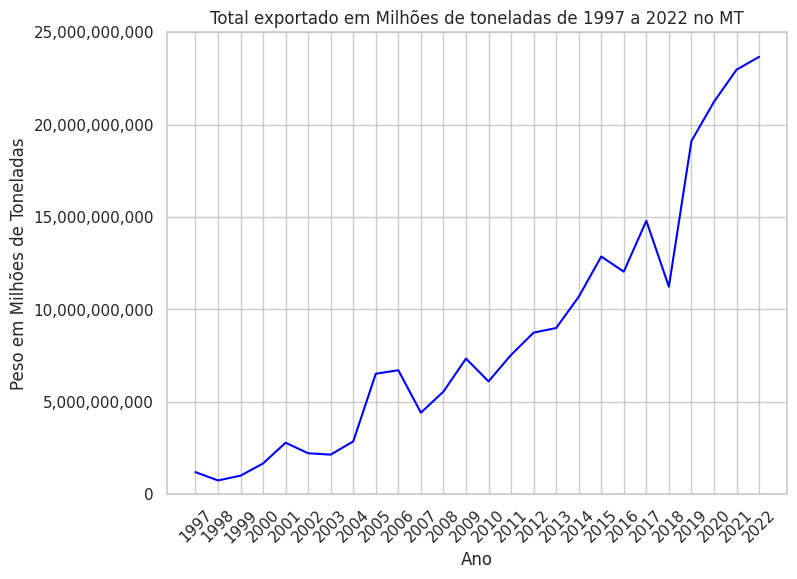

In [ ]:
#Gráfico de Evolução da exportação (peso_liquido) de soja no MT por ano
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
df.plot(x='ano', y='peso_liquido_kg', kind='line', ax=ax, color='blue', legend=False)
ax.set_xlabel('Ano')
ax.set_ylabel('Peso em Milhões de Toneladas')
ax.set_title('Total exportado em Milhões de toneladas de 1997 a 2022 no MT')
ax.ticklabel_format(style='plain', axis='y')

# Definindo os intervalos e rótulos para o eixo y
y_ticks = ax.get_yticks()
ax.set_yticks(y_ticks)
ax.set_yticklabels([f'{int(tick):,}' for tick in y_ticks])
ax.set_ylim(bottom=0)

# Definindo os rótulos dos anos no eixo x
years = range(1997, 2023)  # Substitua 2024 pelo ano atual, se necessário
ax.set_xticks(years)
ax.set_xticklabels(years, rotation=45)
plt.show()
ax.figure.savefig("mt_evolucao.svg", transparent=True, format='svg')

In [ ]:
# Temporalidade da exportação de soja por mês no MT de 1997 a 2023
query = '''
SELECT sigla_uf, ano, mes, SUM(peso_liquido_kg) as peso_liquido_kg, SUM(valor_fob_dolar) as valor_fob_dolar
FROM (
  SELECT ano, id_municipio, sigla_uf, id_sh4, SUM(peso_liquido_kg) as peso_liquido_kg, SUM(valor_fob_dolar) as valor_fob_dolar, mes
  FROM `basedosdados.br_me_comex_stat.municipio_exportacao`
  WHERE id_sh4 = '1201'
  GROUP BY ano, id_municipio, sigla_uf, id_sh4, mes
) subquery
WHERE sigla_uf = 'MT'
GROUP BY sigla_uf, ano, mes
ORDER BY ano DESC, mes DESC
'''
df = bd.read_sql(query, billing_project_id='seu-billing-id')

Downloading: 100%|██████████| 308/308 [00:00<00:00, 856.97rows/s]


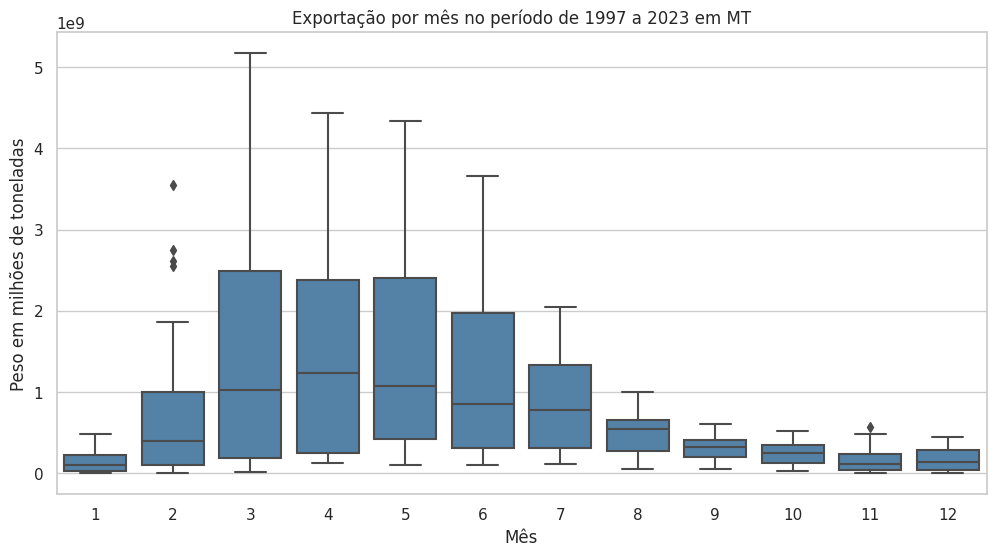

AttributeError: ignored

In [ ]:
import seaborn as sns
from matplotlib.colors import ListedColormap
sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))
# Criar o boxplot com uma cor fixa
sns.boxplot(x='mes', y='peso_liquido_kg', data=df, color='steelblue')
# Configurar os rótulos dos eixos e o título
plt.xlabel('Mês')
plt.ylabel('Peso em milhões de toneladas')
plt.title('Exportação por mês no período de 1997 a 2023 em MT')
# Exibir o gráfico
plt.figure.savefig("mt_evolucao_mes.svg", transparent=True, format='svg')
plt.show()

In [ ]:
#Total de Exportação em todo o período por UF e Porcentagem para a China
query = '''
SELECT sigla_uf,
       SUM(peso_liquido_kg) as peso_liquido_kg,
       SUM(valor_fob_dolar) as valor_fob_dolar,
       (SUM(peso_liquido_kg) / total_peso_liquido_kg) * 100 as porcentagem_peso,
       (SUM(valor_fob_dolar) / total_valor_fob_dolar) * 100 as porcentagem_valor
FROM (
  SELECT ano,
         id_municipio,
         sigla_uf,
         id_sh4,
         SUM(peso_liquido_kg) as peso_liquido_kg,
         SUM(valor_fob_dolar) as valor_fob_dolar
  FROM `basedosdados.br_me_comex_stat.municipio_exportacao`
  WHERE id_sh4 = '1201' AND id_pais = '160'
  GROUP BY ano, id_municipio, sigla_uf, id_sh4
) subquery
CROSS JOIN (
  SELECT SUM(peso_liquido_kg) as total_peso_liquido_kg,
         SUM(valor_fob_dolar) as total_valor_fob_dolar
  FROM (
    SELECT ano,
           id_municipio,
           sigla_uf,
           id_sh4,
           SUM(peso_liquido_kg) as peso_liquido_kg,
           SUM(valor_fob_dolar) as valor_fob_dolar
    FROM `basedosdados.br_me_comex_stat.municipio_exportacao`
    WHERE id_sh4 = '1201'
    GROUP BY ano, id_municipio, sigla_uf, id_sh4
  ) subquery
) totals
GROUP BY sigla_uf, total_peso_liquido_kg, total_valor_fob_dolar
ORDER BY valor_fob_dolar DESC
'''
df = bd.read_sql(query, billing_project_id='seu-billing-id')

Downloading: 100%|██████████| 26/26 [00:00<00:00, 116.59rows/s]


In [ ]:
# Qual estado exportou mais soja por ano?
query = '''
SELECT ano, sigla_uf, SUM(peso_liquido_kg) as total_exportado
FROM `basedosdados.br_me_comex_stat.municipio_exportacao` as t
WHERE id_sh4 = '1201'
GROUP BY ano, sigla_uf
HAVING total_exportado = (
   SELECT MAX(total_exportado)
   FROM (
       SELECT ano, sigla_uf, SUM(peso_liquido_kg) as total_exportado
       FROM `basedosdados.br_me_comex_stat.municipio_exportacao`
       WHERE id_sh4 = '1201' AND ano >=1997 AND ano <= 2022
       GROUP BY ano, sigla_uf
   ) as subquery
   WHERE subquery.ano = t.ano
)
ORDER by t.ano DESC
'''
df = bd.read_sql(query, billing_project_id='seu-billing-id')

Downloading: 100%|██████████| 26/26 [00:00<00:00, 157.42rows/s]


In [ ]:
#Quais os principais países que consomem soja do MT?
query =
'''
with exportacao as (
SELECT id_pais, SUM(peso_liquido_kg) as total_exportado
FROM `basedosdados.br_me_comex_stat.municipio_exportacao`
WHERE id_sh4 = '1201' and sigla_uf = 'MT'
GROUP BY id_pais
ORDER BY total_exportado DESC
LIMIT 10),

dicionario as (
  SELECT DISTINCT chave, TRANSLATE(valor, 'áàãâäéèêëíìîïóòõôöúùûüçÁÀÃÂÄÉÈÊËÍÌÎÏÓÒÕÔÖÚÙÛÜÇ', 'aaaaaeeeeiiiiooooouuuucAAAAAEEEEIIIIOOOOOUUUUC') as valor
  FROM `basedosdados.br_me_comex_stat.dicionario`
  where id_tabela = 'municipio_exportacao' and coluna = 'id_pais'
  group by chave, valor
)
select * from exportacao t1
join dicionario t2
on t1.id_pais = t2.chave
'''
df = bd.read_sql(query, billing_project_id='seu-billing-id')

#O gráfico Sankey foi elaborado a partir do Flourish e você pode visualiza-lo aqui (Coopie e cole o código no seu navegador sem o #):
#
#https://public.flourish.studio/visualisation/14055164/